In [1]:
import deepchem as dc
from deepchem.feat.graph_data import GraphData
from deepchem.feat import MolGraphConvFeaturizer
import numpy as np
import pandas as pd

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (C:\Users\yyyyx\miniconda3\envs\deepchem\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
df = pd.read_csv('./Pgp.csv')

In [3]:
df

,Unnamed: 0,Drug_ID,Drug,Y
0,0,"3,5,7-Trihydroxy-3',4',5'-trimethoxyflavone",COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2O)cc(OC)c1OC,1
1,1,"3,6,3',4'-Tetramethoxyflavone",COc1ccc2oc(-c3ccc(OC)c(OC)c3)c(OC)c(=O)c2c1,1
2,2,"3,7-Dihydroxy-3',4'-dimethoxyflavone",COc1ccc(-c2oc3cc(O)ccc3c(=O)c2O)cc1OC,1
3,3,"3',4'-Dimethoxyflavone",COc1ccc(-c2cc(=O)c3ccccc3o2)cc1OC,1
4,4,"5,6,7,3',4'-Pentamethoxyflavone",COc1ccc(-c2cc(=O)c3c(OC)c(OC)c(OC)cc3o2)cc1OC,1
...,...,...,...,...
1213,1213,"N'-(5-chloronaphthalen-1-yl)sulfanylhexane-1,6...",NCCCCCCNSc1cccc2c(Cl)cccc12,0
1214,1214,N-(6-aminohexyl)-5-chloronaphthalene-1-sulfona...,NCCCCCCNS(=O)(=O)c1cccc2c(Cl)cccc12,0
1215,1215,Zolamine,COc1ccc(CN(CCN(C)C)c2nccs2)cc1,0
1216,1216,Zolertine,c1ccc(N2CCN(CCc3nn[nH]n3)CC2)cc1,0


In [4]:
# 1. SMILES에서 그래프 형식으로 변환
featurizer = MolGraphConvFeaturizer()
features = featurizer.featurize(df["Drug"])  # Smiles 컬럼에서 특징 추출

In [5]:
features

array([GraphData(node_features=[26, 30], edge_index=[2, 56], edge_features=None),
       GraphData(node_features=[25, 30], edge_index=[2, 54], edge_features=None),
       GraphData(node_features=[23, 30], edge_index=[2, 50], edge_features=None),
       ...,
       GraphData(node_features=[20, 30], edge_index=[2, 42], edge_features=None),
       GraphData(node_features=[19, 30], edge_index=[2, 42], edge_features=None),
       GraphData(node_features=[32, 30], edge_index=[2, 68], edge_features=None)],
      dtype=object)

In [6]:
# 2. 레이블 설정 (pIC50)
labels = df["Y"].values

In [7]:
# 3. 가중치 (필요시 기본값으로 1 설정)
weights = None  # 기본적으로 None으로 설정. 커스텀 가중치가 있으면 지정.

# 4. 데이터셋 생성
dataset = dc.data.NumpyDataset(X=features, y=labels, w=weights)

In [8]:
dataset

<NumpyDataset X.shape: (1218,), y.shape: (1218,), w.shape: (1218,), task_names: [0]>

In [9]:
# 데이터셋 확인
print(f"Number of samples in dataset: {len(dataset)}")
print(f"Feature shape: {dataset.X[0].node_features.shape[0]} nodes, {dataset.X[0].edge_index.shape[1]} edges")
print(f"First label: {dataset.y[0]}")

Number of samples in dataset: 1218
Feature shape: 26 nodes, 56 edges
First label: 1


In [10]:
# 데이터셋을 Train/Validation/Test로 나누기
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# 확인
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 974
Validation dataset size: 122
Test dataset size: 122


In [22]:
# GCNModel 초기화
model = dc.models.GCNModel(
    n_tasks=1,
    graph_conv_layers=[64, 64],
    dense_layer_size=128,
    dropout=0.2,
    mode='classification',
    learning_rate=1e-3,
    batch_size=128,
)

In [23]:
%%time
model.fit(train_dataset, nb_epoch=10)

CPU times: total: 8min 19s
Wall time: 2min 2s


0.4540410995483398

In [29]:
# GCNModel 초기화
model_100 = dc.models.GCNModel(
    n_tasks=1,
    graph_conv_layers=[64, 64],
    dense_layer_size=128,
    dropout=0.2,
    mode='classification',
    learning_rate=1e-3,
    batch_size=128,
)

In [30]:
%%time
model_100.fit(train_dataset, nb_epoch=100)

CPU times: total: 6min 15s
Wall time: 1min 31s


0.17730518341064452

In [24]:
# 1. Test 데이터셋에 대한 예측값 추론
y_pred = model.predict(test_dataset)

In [39]:
y_pred

array([[0.21955888, 0.7804411 ],
       [0.9458859 , 0.05411407],
       [0.63302875, 0.36697122],
       ...,
       [0.2772778 , 0.72272223],
       [0.49547833, 0.50452167],
       [0.97122735, 0.02877263]], dtype=float32)

In [25]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('Training set score:', model.evaluate(train_dataset, [metric]))
print('Training set score:', model.evaluate(test_dataset, [metric]))
print('Training set score:', model.evaluate(valid_dataset, [metric]))

Training set score: {'roc_auc_score': 0.8778793925069039}
Training set score: {'roc_auc_score': 0.8686157852670136}
Training set score: {'roc_auc_score': 0.8618538833959559}


In [31]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('Training set score:', model_100.evaluate(train_dataset, [metric]))
print('Training set score:', model_100.evaluate(test_dataset, [metric]))
print('Training set score:', model_100.evaluate(valid_dataset, [metric]))

Training set score: {'roc_auc_score': 0.97754662375384}
Training set score: {'roc_auc_score': 0.8440225035161744}
Training set score: {'roc_auc_score': 0.9118279569892473}


In [19]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric]))
print("Test set score:", model.evaluate(test_dataset, [metric]))

Training set score: {'pearson_r2_score': 0.8728071088137395}
Test set score: {'pearson_r2_score': 0.7761037587217018}


In [18]:
# 모델 평가 / GPT 파라미터 버전
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
train_score = model.evaluate(train_dataset, [metric])
valid_score = model.evaluate(valid_dataset, [metric])

print("Train score:", train_score)
print("Validation score:", valid_score)

Train score: {'pearson_r2_score': 0.8631181271812122}
Validation score: {'pearson_r2_score': 0.7911024220563603}


In [19]:
###############################################################################
# 4. 모델 평가
###############################################################################
# 평가지표 설정 (예: R^2 스코어, MAE, RMSE 등)
metric_r2 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric_mae = dc.metrics.Metric(dc.metrics.mean_absolute_error)

print("Train R^2: ", model.evaluate(train_dataset, [metric_r2]))
print("Valid R^2: ", model.evaluate(valid_dataset, [metric_r2]))
print("Test  R^2: ", model.evaluate(test_dataset, [metric_r2]))

print("Train MAE: ", model.evaluate(train_dataset, [metric_mae]))
print("Valid MAE: ", model.evaluate(valid_dataset, [metric_mae]))
print("Test  MAE: ", model.evaluate(test_dataset, [metric_mae]))


Train R^2:  {'pearson_r2_score': 0.8631181271812122}
Valid R^2:  {'pearson_r2_score': 0.7911024220563603}
Test  R^2:  {'pearson_r2_score': 0.7929518347023322}
Train MAE:  {'mean_absolute_error': 0.7054202499754564}
Valid MAE:  {'mean_absolute_error': 0.7932570925883062}
Test  MAE:  {'mean_absolute_error': 0.7494379179466186}


In [18]:
import numpy as np
# 기존 데이터를 수정
new_train_y = train_dataset.y.reshape(-1)
new_valid_y = valid_dataset.y.reshape(-1)

# 새로운 데이터셋 생성
train_dataset = dc.data.NumpyDataset(X=train_dataset.X, y=new_train_y, w=train_dataset.w, ids=train_dataset.ids)
valid_dataset = dc.data.NumpyDataset(X=valid_dataset.X, y=new_valid_y, w=valid_dataset.w, ids=valid_dataset.ids)


In [19]:
train_dataset

<NumpyDataset X.shape: (1624,), y.shape: (1624,), w.shape: (1624,), task_names: [0]>

In [14]:
print(train_dataset.y.shape)
print(test_dataset.y.shape)
print(valid_dataset.y.shape)

(974,)
(122,)
(122,)


In [15]:
print("Unique train labels:", np.unique(train_dataset.y))
print("Unique train labels:", np.unique(test_dataset.y))
print("Unique valid labels:", np.unique(valid_dataset.y))


Unique train labels: [0 1]
Unique train labels: [0 1]
Unique valid labels: [0 1]


In [16]:
metric_list = [
    dc.metrics.Metric(dc.metrics.roc_auc_score, name='roc_auc_score'),
    dc.metrics.Metric(dc.metrics.accuracy_score, name='accuracy_score'),
    #dc.metrics.Metric(dc.metrics.precision_score, name='precision_score', average='binary'),
    #dc.metrics.Metric(dc.metrics.recall_score, name='recall_score', average='binary'),
    #dc.metrics.Metric(dc.metrics.f1_score, name='f1_score', average='binary'),
    #dc.metrics.Metric(dc.metrics.matthews_corrcoef, name='mcc_score')
]

In [17]:
import pandas as pd
import deepchem as dc
from itertools import product
from tqdm import tqdm

# 하이퍼파라미터 설정
param_grid = {
    'graph_conv_layers': [[64, 64], [128, 128], [64, 128, 64]],
    'dense_layer_size': [128, 256],
    'dropout': [0.2, 0.3],
    'learning_rate': [1e-3, 5e-4, 1e-4]
}

# 하이퍼파라미터 조합 생성
combinations = list(product(
    param_grid['graph_conv_layers'],
    param_grid['dense_layer_size'],
    param_grid['dropout'],
    param_grid['learning_rate']
))

# 결과 저장 리스트 초기화
results = []

# 데이터셋과 평가 지표가 준비되었다고 가정
# train_dataset, valid_dataset: DeepChem의 NumpyDataset 형식
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

# 그리드 서치 진행
for idx, (graph_conv_layers, dense_layer_size, dropout, learning_rate) in enumerate(
    tqdm(combinations, desc="Grid Search Progress")):
    
    print(f"\nRunning combination {idx + 1}/{len(combinations)}:")
    print(f"graph_conv_layers: {graph_conv_layers}, dense_layer_size: {dense_layer_size}, "
          f"dropout: {dropout}, learning_rate: {learning_rate}")
    
    try:
        # 모델 생성
        model = dc.models.GCNModel(
            n_tasks=1,
            graph_conv_layers=graph_conv_layers,
            dense_layer_size=dense_layer_size,
            dropout=dropout,
            mode='classification',
            learning_rate=learning_rate,
            batch_size=128
        )
        
        # 모델 학습
        model.fit(train_dataset, nb_epoch=10)
        
        # 모델 평가 (train, valid 각각)
        train_scores = model.evaluate(train_dataset, metric_list)
        valid_scores = model.evaluate(valid_dataset, metric_list)
        
        # 결과 저장용 딕셔너리 생성
        result_dict = {
            'graph_conv_layers': graph_conv_layers,
            'dense_layer_size': dense_layer_size,
            'dropout': dropout,
            'learning_rate': learning_rate,
            'batch_size': 128
        }
        
        # train 스코어 (roc_auc, accuracy, precision 등)
        for metric_name, metric_value in train_scores.items():
            result_dict[f'train_{metric_name}'] = metric_value
        
        # valid 스코어 (roc_auc, accuracy, precision 등)
        for metric_name, metric_value in valid_scores.items():
            result_dict[f'valid_{metric_name}'] = metric_value
        
        results.append(result_dict)
        
        # 로그 표시
        print("Train Scores:", train_scores)
        print("Valid Scores:", valid_scores)
        
    except Exception as e:
        print(f"Error during training for combination {idx + 1}: {e}")

# 모든 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

Grid Search Progress:   0%|                                                                     | 0/36 [00:00<?, ?it/s]


Running combination 1/36:
graph_conv_layers: [64, 64], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.001


Grid Search Progress:   3%|█▋                                                           | 1/36 [00:07<04:33,  7.83s/it]

Train Scores: {'roc_auc_score': 0.9310804802134283, 'accuracy_score': 0.8675564681724846}
Valid Scores: {'roc_auc_score': 0.9143882905274786, 'accuracy_score': 0.860655737704918}

Running combination 2/36:
graph_conv_layers: [64, 64], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.0005


Grid Search Progress:   6%|███▍                                                         | 2/36 [00:14<04:01,  7.12s/it]

Train Scores: {'roc_auc_score': 0.9330538440365029, 'accuracy_score': 0.8706365503080082}
Valid Scores: {'roc_auc_score': 0.9212924606462304, 'accuracy_score': 0.8524590163934426}

Running combination 3/36:
graph_conv_layers: [64, 64], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.0001


Grid Search Progress:   8%|█████                                                        | 3/36 [00:20<03:43,  6.77s/it]

Train Scores: {'roc_auc_score': 0.9166274958182472, 'accuracy_score': 0.8203285420944558}
Valid Scores: {'roc_auc_score': 0.9080364540182271, 'accuracy_score': 0.7868852459016393}

Running combination 4/36:
graph_conv_layers: [64, 64], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.001


Grid Search Progress:  11%|██████▊                                                      | 4/36 [00:27<03:34,  6.70s/it]

Train Scores: {'roc_auc_score': 0.9252789599610409, 'accuracy_score': 0.8603696098562629}
Valid Scores: {'roc_auc_score': 0.9143882905274786, 'accuracy_score': 0.860655737704918}

Running combination 5/36:
graph_conv_layers: [64, 64], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.0005


Grid Search Progress:  14%|████████▍                                                    | 5/36 [00:34<03:27,  6.70s/it]

Train Scores: {'roc_auc_score': 0.9327531813080946, 'accuracy_score': 0.8655030800821355}
Valid Scores: {'roc_auc_score': 0.9268157967412316, 'accuracy_score': 0.8852459016393442}

Running combination 6/36:
graph_conv_layers: [64, 64], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.0001


Grid Search Progress:  17%|██████████▏                                                  | 6/36 [00:40<03:16,  6.55s/it]

Train Scores: {'roc_auc_score': 0.9060788922060599, 'accuracy_score': 0.8388090349075975}
Valid Scores: {'roc_auc_score': 0.8947804473902237, 'accuracy_score': 0.8278688524590164}

Running combination 7/36:
graph_conv_layers: [64, 64], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.001


Grid Search Progress:  19%|███████████▊                                                 | 7/36 [00:46<03:09,  6.52s/it]

Train Scores: {'roc_auc_score': 0.934438586461708, 'accuracy_score': 0.8706365503080082}
Valid Scores: {'roc_auc_score': 0.9287489643744822, 'accuracy_score': 0.8770491803278688}

Running combination 8/36:
graph_conv_layers: [64, 64], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.0005


Grid Search Progress:  22%|█████████████▌                                               | 8/36 [00:53<03:02,  6.52s/it]

Train Scores: {'roc_auc_score': 0.9288572698977324, 'accuracy_score': 0.8613963039014374}
Valid Scores: {'roc_auc_score': 0.9210162938414803, 'accuracy_score': 0.8852459016393442}

Running combination 9/36:
graph_conv_layers: [64, 64], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.0001


Grid Search Progress:  25%|███████████████▎                                             | 9/36 [00:59<02:56,  6.55s/it]

Train Scores: {'roc_auc_score': 0.9093480700417117, 'accuracy_score': 0.8439425051334702}
Valid Scores: {'roc_auc_score': 0.8771057718862192, 'accuracy_score': 0.819672131147541}

Running combination 10/36:
graph_conv_layers: [64, 64], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.001


Grid Search Progress:  28%|████████████████▋                                           | 10/36 [01:06<02:49,  6.53s/it]

Train Scores: {'roc_auc_score': 0.9353490440195644, 'accuracy_score': 0.864476386036961}
Valid Scores: {'roc_auc_score': 0.9221209610604806, 'accuracy_score': 0.9016393442622951}

Running combination 11/36:
graph_conv_layers: [64, 64], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.0005


Grid Search Progress:  31%|██████████████████▎                                         | 11/36 [01:12<02:40,  6.44s/it]

Train Scores: {'roc_auc_score': 0.9215651400622499, 'accuracy_score': 0.7731006160164271}
Valid Scores: {'roc_auc_score': 0.9141121237227285, 'accuracy_score': 0.8114754098360656}

Running combination 12/36:
graph_conv_layers: [64, 64], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.0001


Grid Search Progress:  33%|████████████████████                                        | 12/36 [01:19<02:35,  6.48s/it]

Train Scores: {'roc_auc_score': 0.9139681128120434, 'accuracy_score': 0.851129363449692}
Valid Scores: {'roc_auc_score': 0.9069317867992268, 'accuracy_score': 0.8524590163934426}

Running combination 13/36:
graph_conv_layers: [128, 128], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.001


Grid Search Progress:  36%|█████████████████████▋                                      | 13/36 [01:25<02:28,  6.47s/it]

Train Scores: {'roc_auc_score': 0.9366660314637194, 'accuracy_score': 0.8747433264887063}
Valid Scores: {'roc_auc_score': 0.9171499585749793, 'accuracy_score': 0.8688524590163934}

Running combination 14/36:
graph_conv_layers: [128, 128], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.0005


Grid Search Progress:  39%|███████████████████████▎                                    | 14/36 [01:32<02:23,  6.53s/it]

Train Scores: {'roc_auc_score': 0.936365368735311, 'accuracy_score': 0.8685831622176592}
Valid Scores: {'roc_auc_score': 0.9182546257939797, 'accuracy_score': 0.8688524590163934}

Running combination 15/36:
graph_conv_layers: [128, 128], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.0001


Grid Search Progress:  42%|█████████████████████████                                   | 15/36 [01:38<02:16,  6.50s/it]

Train Scores: {'roc_auc_score': 0.9137817866141565, 'accuracy_score': 0.8408624229979466}
Valid Scores: {'roc_auc_score': 0.9066556199944766, 'accuracy_score': 0.8360655737704918}

Running combination 16/36:
graph_conv_layers: [128, 128], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.001


Grid Search Progress:  44%|██████████████████████████▋                                 | 16/36 [01:45<02:09,  6.47s/it]

Train Scores: {'roc_auc_score': 0.9366533274047724, 'accuracy_score': 0.8634496919917864}
Valid Scores: {'roc_auc_score': 0.9204639602319801, 'accuracy_score': 0.860655737704918}

Running combination 17/36:
graph_conv_layers: [128, 128], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.0005


Grid Search Progress:  47%|████████████████████████████▎                               | 17/36 [01:51<02:03,  6.49s/it]

Train Scores: {'roc_auc_score': 0.9270024772914947, 'accuracy_score': 0.8552361396303901}
Valid Scores: {'roc_auc_score': 0.916045291355979, 'accuracy_score': 0.8114754098360656}

Running combination 18/36:
graph_conv_layers: [128, 128], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.0001


Grid Search Progress:  50%|██████████████████████████████                              | 18/36 [01:58<01:55,  6.43s/it]

Train Scores: {'roc_auc_score': 0.9116898515742446, 'accuracy_score': 0.8418891170431212}
Valid Scores: {'roc_auc_score': 0.9052747859707263, 'accuracy_score': 0.8032786885245902}

Running combination 19/36:
graph_conv_layers: [128, 128], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.001


Grid Search Progress:  53%|███████████████████████████████▋                            | 19/36 [02:04<01:50,  6.50s/it]

Train Scores: {'roc_auc_score': 0.9331131296449215, 'accuracy_score': 0.8593429158110883}
Valid Scores: {'roc_auc_score': 0.9163214581607291, 'accuracy_score': 0.8688524590163934}

Running combination 20/36:
graph_conv_layers: [128, 128], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.0005


Grid Search Progress:  56%|█████████████████████████████████▎                          | 20/36 [02:11<01:45,  6.56s/it]

Train Scores: {'roc_auc_score': 0.9345486883059138, 'accuracy_score': 0.7885010266940452}
Valid Scores: {'roc_auc_score': 0.9188069594034796, 'accuracy_score': 0.8114754098360656}

Running combination 21/36:
graph_conv_layers: [128, 128], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.0001


Grid Search Progress:  58%|███████████████████████████████████                         | 21/36 [02:17<01:36,  6.45s/it]

Train Scores: {'roc_auc_score': 0.9197781024370619, 'accuracy_score': 0.8429158110882957}
Valid Scores: {'roc_auc_score': 0.9130074565037283, 'accuracy_score': 0.7950819672131147}

Running combination 22/36:
graph_conv_layers: [128, 128], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.001


Grid Search Progress:  61%|████████████████████████████████████▋                       | 22/36 [02:24<01:30,  6.47s/it]

Train Scores: {'roc_auc_score': 0.9318511931228693, 'accuracy_score': 0.8655030800821355}
Valid Scores: {'roc_auc_score': 0.9207401270367301, 'accuracy_score': 0.8770491803278688}

Running combination 23/36:
graph_conv_layers: [128, 128], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.0005


Grid Search Progress:  64%|██████████████████████████████████████▎                     | 23/36 [02:30<01:24,  6.48s/it]

Train Scores: {'roc_auc_score': 0.9321052743018061, 'accuracy_score': 0.8706365503080082}
Valid Scores: {'roc_auc_score': 0.9177022921844795, 'accuracy_score': 0.8688524590163934}

Running combination 24/36:
graph_conv_layers: [128, 128], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.0001


Grid Search Progress:  67%|████████████████████████████████████████                    | 24/36 [02:36<01:17,  6.45s/it]

Train Scores: {'roc_auc_score': 0.8958775328717525, 'accuracy_score': 0.7864476386036962}
Valid Scores: {'roc_auc_score': 0.8812482739574703, 'accuracy_score': 0.7540983606557377}

Running combination 25/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.001


Grid Search Progress:  69%|█████████████████████████████████████████▋                  | 25/36 [02:43<01:11,  6.53s/it]

Train Scores: {'roc_auc_score': 0.9303605835397744, 'accuracy_score': 0.8655030800821355}
Valid Scores: {'roc_auc_score': 0.9212924606462303, 'accuracy_score': 0.860655737704918}

Running combination 26/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.0005


Grid Search Progress:  72%|███████████████████████████████████████████▎                | 26/36 [02:50<01:04,  6.49s/it]

Train Scores: {'roc_auc_score': 0.9077388892417795, 'accuracy_score': 0.8490759753593429}
Valid Scores: {'roc_auc_score': 0.9157691245512289, 'accuracy_score': 0.860655737704918}

Running combination 27/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 128, dropout: 0.2, learning_rate: 0.0001


Grid Search Progress:  75%|█████████████████████████████████████████████               | 27/36 [02:56<00:59,  6.61s/it]

Train Scores: {'roc_auc_score': 0.9036862944377395, 'accuracy_score': 0.8213552361396304}
Valid Scores: {'roc_auc_score': 0.9066556199944766, 'accuracy_score': 0.7950819672131147}

Running combination 28/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.001


Grid Search Progress:  78%|██████████████████████████████████████████████▋             | 28/36 [03:03<00:53,  6.64s/it]

Train Scores: {'roc_auc_score': 0.9249444197421075, 'accuracy_score': 0.8254620123203286}
Valid Scores: {'roc_auc_score': 0.9185307925987296, 'accuracy_score': 0.860655737704918}

Running combination 29/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.0005


Grid Search Progress:  81%|████████████████████████████████████████████████▎           | 29/36 [03:10<00:45,  6.55s/it]

Train Scores: {'roc_auc_score': 0.9156704567109191, 'accuracy_score': 0.4702258726899384}
Valid Scores: {'roc_auc_score': 0.9102457884562276, 'accuracy_score': 0.4180327868852459}

Running combination 30/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 128, dropout: 0.3, learning_rate: 0.0001


Grid Search Progress:  83%|██████████████████████████████████████████████████          | 30/36 [03:16<00:39,  6.61s/it]

Train Scores: {'roc_auc_score': 0.9014757881809905, 'accuracy_score': 0.8100616016427105}
Valid Scores: {'roc_auc_score': 0.8994752830709749, 'accuracy_score': 0.8032786885245902}

Running combination 31/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.001


Grid Search Progress:  86%|███████████████████████████████████████████████████▋        | 31/36 [03:23<00:33,  6.61s/it]

Train Scores: {'roc_auc_score': 0.9311651739397404, 'accuracy_score': 0.8655030800821355}
Valid Scores: {'roc_auc_score': 0.923777961888981, 'accuracy_score': 0.8524590163934426}

Running combination 32/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.0005


Grid Search Progress:  89%|█████████████████████████████████████████████████████▎      | 32/36 [03:30<00:26,  6.62s/it]

Train Scores: {'roc_auc_score': 0.9217811090643461, 'accuracy_score': 0.8552361396303901}
Valid Scores: {'roc_auc_score': 0.9141121237227285, 'accuracy_score': 0.8524590163934426}

Running combination 33/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 256, dropout: 0.2, learning_rate: 0.0001


Grid Search Progress:  92%|███████████████████████████████████████████████████████     | 33/36 [03:36<00:19,  6.61s/it]

Train Scores: {'roc_auc_score': 0.8996040568294904, 'accuracy_score': 0.8429158110882957}
Valid Scores: {'roc_auc_score': 0.9055509527754764, 'accuracy_score': 0.8360655737704918}

Running combination 34/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.001


Grid Search Progress:  94%|████████████████████████████████████████████████████████▋   | 34/36 [03:43<00:13,  6.64s/it]

Train Scores: {'roc_auc_score': 0.9251815621757818, 'accuracy_score': 0.8634496919917864}
Valid Scores: {'roc_auc_score': 0.9221209610604806, 'accuracy_score': 0.8852459016393442}

Running combination 35/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.0005


Grid Search Progress:  97%|██████████████████████████████████████████████████████████▎ | 35/36 [03:49<00:06,  6.60s/it]

Train Scores: {'roc_auc_score': 0.9129009718605094, 'accuracy_score': 0.8459958932238193}
Valid Scores: {'roc_auc_score': 0.9193592930129798, 'accuracy_score': 0.8524590163934426}

Running combination 36/36:
graph_conv_layers: [64, 128, 64], dense_layer_size: 256, dropout: 0.3, learning_rate: 0.0001


Grid Search Progress: 100%|████████████████████████████████████████████████████████████| 36/36 [03:56<00:00,  6.57s/it]

Train Scores: {'roc_auc_score': 0.8999047195578986, 'accuracy_score': 0.8151950718685832}
Valid Scores: {'roc_auc_score': 0.8887047776857222, 'accuracy_score': 0.7868852459016393}


In [18]:
results_df

,graph_conv_layers,dense_layer_size,dropout,learning_rate,batch_size,train_roc_auc_score,train_accuracy_score,valid_roc_auc_score,valid_accuracy_score
0,"[64, 64]",128,0.2,0.0010,128,0.931080,0.867556,0.914388,0.860656
1,"[64, 64]",128,0.2,0.0005,128,0.933054,0.870637,0.921292,0.852459
2,"[64, 64]",128,0.2,0.0001,128,0.916627,0.820329,0.908036,0.786885
3,"[64, 64]",128,0.3,0.0010,128,0.925279,0.860370,0.914388,0.860656
4,"[64, 64]",128,0.3,0.0005,128,0.932753,0.865503,0.926816,0.885246
5,"[64, 64]",128,0.3,0.0001,128,0.906079,0.838809,0.894780,0.827869
6,"[64, 64]",256,0.2,0.0010,128,0.934439,0.870637,0.928749,0.877049
7,"[64, 64]",256,0.2,0.0005,128,0.928857,0.861396,0.921016,0.885246
8,"[64, 64]",256,0.2,0.0001,128,0.909348,0.843943,0.877106,0.819672
9,"[64, 64]",256,0.3,0.0010,128,0.935349,0.864476,0.922121,0.901639


In [19]:
# 유효성 점수 기준으로 정렬
results_df = results_df.sort_values(by='valid_roc_auc_score', ascending=False)

# 결과 저장
results_df.to_csv("gridsearch_results_Pgp.csv", index=False)

# 상위 결과 출력
print("\nTop Results:")
print(results_df.head())


Top Results:
   graph_conv_layers  dense_layer_size  dropout  learning_rate  batch_size  \
6           [64, 64]               256      0.2         0.0010         128   
4           [64, 64]               128      0.3         0.0005         128   
30     [64, 128, 64]               256      0.2         0.0010         128   
9           [64, 64]               256      0.3         0.0010         128   
33     [64, 128, 64]               256      0.3         0.0010         128   

    train_roc_auc_score  train_accuracy_score  valid_roc_auc_score  \
6              0.934439              0.870637             0.928749   
4              0.932753              0.865503             0.926816   
30             0.931165              0.865503             0.923778   
9              0.935349              0.864476             0.922121   
33             0.925182              0.863450             0.922121   

    valid_accuracy_score  
6               0.877049  
4               0.885246  
30             

In [24]:
train_score = model.evaluate(train_dataset, [metric])
valid_score = model.evaluate(valid_dataset, [metric])

In [25]:
train_score

{'roc_auc_score': 0.8597077660031655}

In [11]:
results_df = pd.read_csv('./gridsearch_results_Pgp.csv')

In [12]:
# ROC AUC score 순
results_df.head(10)

,graph_conv_layers,dense_layer_size,dropout,learning_rate,batch_size,train_roc_auc_score,train_accuracy_score,valid_roc_auc_score,valid_accuracy_score
0,"[64, 64]",256,0.2,0.0010,128,0.934439,0.870637,0.928749,0.877049
1,"[64, 64]",128,0.3,0.0005,128,0.932753,0.865503,0.926816,0.885246
2,"[64, 128, 64]",256,0.2,0.0010,128,0.931165,0.865503,0.923778,0.852459
3,"[64, 64]",256,0.3,0.0010,128,0.935349,0.864476,0.922121,0.901639
4,"[64, 128, 64]",256,0.3,0.0010,128,0.925182,0.863450,0.922121,0.885246
5,"[64, 64]",128,0.2,0.0005,128,0.933054,0.870637,0.921292,0.852459
6,"[64, 128, 64]",128,0.2,0.0010,128,0.930361,0.865503,0.921292,0.860656
7,"[64, 64]",256,0.2,0.0005,128,0.928857,0.861396,0.921016,0.885246
8,"[128, 128]",256,0.3,0.0010,128,0.931851,0.865503,0.920740,0.877049
9,"[128, 128]",128,0.3,0.0010,128,0.936653,0.863450,0.920464,0.860656


In [13]:
results_df.sort_values(by='valid_accuracy_score', ascending=False).head(10)

,graph_conv_layers,dense_layer_size,dropout,learning_rate,batch_size,train_roc_auc_score,train_accuracy_score,valid_roc_auc_score,valid_accuracy_score
3,"[64, 64]",256,0.3,0.0010,128,0.935349,0.864476,0.922121,0.901639
4,"[64, 128, 64]",256,0.3,0.0010,128,0.925182,0.863450,0.922121,0.885246
1,"[64, 64]",128,0.3,0.0005,128,0.932753,0.865503,0.926816,0.885246
7,"[64, 64]",256,0.2,0.0005,128,0.928857,0.861396,0.921016,0.885246
0,"[64, 64]",256,0.2,0.0010,128,0.934439,0.870637,0.928749,0.877049
8,"[128, 128]",256,0.3,0.0010,128,0.931851,0.865503,0.920740,0.877049
13,"[128, 128]",128,0.2,0.0005,128,0.936365,0.868583,0.918255,0.868852
16,"[128, 128]",256,0.2,0.0010,128,0.933113,0.859343,0.916321,0.868852
15,"[128, 128]",128,0.2,0.0010,128,0.936666,0.874743,0.917150,0.868852
14,"[128, 128]",256,0.3,0.0005,128,0.932105,0.870637,0.917702,0.868852


In [33]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [14]:
# accuracy score 1등
model_1st = dc.models.GCNModel(
    n_tasks=1,
    graph_conv_layers=[64,  64],
    dense_layer_size=256,
    dropout=0.3,
    mode='classification',
    learning_rate=0.001,
    batch_size=128,
)
# rocauc score 1등
model_2nd = dc.models.GCNModel(
    n_tasks=1,
    graph_conv_layers=[64, 64],
    dense_layer_size=256,
    dropout=0.2,
    mode='classification',
    learning_rate=0.001,
    batch_size=128,
)
# # rocauc score 3등 + accuracy 0.73
# model_3rd = dc.models.GCNModel(
#     n_tasks=1,
#     graph_conv_layers=[128, 128],
#     dense_layer_size=256,
#     dropout=0.2,
#     mode='classification',
#     learning_rate=0.001,
#     batch_size=128,
# )
# # accuracy score 2등
# model_4th = dc.models.GCNModel(
#     n_tasks=1,
#     graph_conv_layers=[64, 64],
#     dense_layer_size=256,
#     dropout=0.2,
#     mode='classification',
#     learning_rate=0.001,
#     batch_size=128,
# )

In [17]:
# 데이터셋과 평가 지표가 준비되었다고 가정
# train_dataset, valid_dataset: DeepChem의 NumpyDataset 형식
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [15]:
%%time
model_1st.fit(train_dataset, nb_epoch=100)

CPU times: total: 3min 45s
Wall time: 55.9 s


0.2389276123046875

In [18]:
print('Training set score:', model_1st.evaluate(train_dataset, [metric]))
print('Test set score:', model_1st.evaluate(test_dataset, [metric]))
print('Validation set score:', model_1st.evaluate(valid_dataset, [metric]))

Training set score: {'roc_auc_score': 0.9698401408927725}
Test set score: {'roc_auc_score': 0.9455818965517242}
Validation set score: {'roc_auc_score': 0.9055010893246187}


In [19]:
%%time
model_2nd.fit(train_dataset, nb_epoch=100)

CPU times: total: 3min 50s
Wall time: 55.4 s


0.17317129135131837

In [20]:
print('Training set score:', model_2nd.evaluate(train_dataset, [metric]))
print('Test set score:', model_2nd.evaluate(test_dataset, [metric]))
print('Validation set score:', model_2nd.evaluate(valid_dataset, [metric]))

Training set score: {'roc_auc_score': 0.9887556729661993}
Test set score: {'roc_auc_score': 0.9692887931034482}
Validation set score: {'roc_auc_score': 0.9215686274509804}


In [ ]:
%%time
model_3rd.fit(train_dataset, nb_epoch=100)

In [ ]:
print('Training set score:', model_3rd.evaluate(train_dataset, [metric]))
print('Test set score:', model_3rd.evaluate(test_dataset, [metric]))
print('Validation set score:', model_3rd.evaluate(valid_dataset, [metric]))

In [ ]:
%%time
model_4th.fit(train_dataset, nb_epoch=100)

In [ ]:
print('Training set score:', model_4th.evaluate(train_dataset, [metric]))
print('Test set score:', model_4th.evaluate(test_dataset, [metric]))
print('Validation set score:', model_4th.evaluate(valid_dataset, [metric]))

In [21]:
import numpy as np

# 테스트셋 예측 (로짓 혹은 확률)
y_pred_prob = model_1st.predict(test_dataset)  
# y_pred_prob.shape: (num_samples, 2)

# 가장 큰 값을 가진 인덱스를 클래스로 결정
y_pred = np.argmax(y_pred_prob, axis=1)

y_pred_valid_prob = model_1st.predict(valid_dataset)  
# y_pred_prob.shape: (num_samples, 2)

# 가장 큰 값을 가진 인덱스를 클래스로 결정
y_pred_valid = np.argmax(y_pred_valid_prob, axis=1)

In [22]:
y_true = test_dataset.y
if len(y_true.shape) == 2 and y_true.shape[1] == 1:
    y_true = y_true.reshape(-1)


In [23]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm_test)


Confusion Matrix:
 [[42 16]
 [ 3 61]]


In [24]:
from sklearn.metrics import confusion_matrix

cm_valid = confusion_matrix(y_true, y_pred_valid)
print("Confusion Matrix:\n", cm_valid)


Confusion Matrix:
 [[22 36]
 [24 40]]


In [29]:
import numpy as np

# 테스트셋 예측 (로짓 혹은 확률)
y_pred_prob_2nd = model_2nd.predict(test_dataset)  
# y_pred_prob.shape: (num_samples, 2)

# 가장 큰 값을 가진 인덱스를 클래스로 결정
y_pred_2nd = np.argmax(y_pred_prob_2nd, axis=1)

y_pred_valid_prob_2nd = model_2nd.predict(valid_dataset)  
# y_pred_prob.shape: (num_samples, 2)

# 가장 큰 값을 가진 인덱스를 클래스로 결정
y_pred_valid_2nd = np.argmax(y_pred_valid_prob_2nd, axis=1)

In [30]:
from sklearn.metrics import confusion_matrix

cm_test_2nd = confusion_matrix(y_true, y_pred_2nd)
print("Confusion Matrix:\n", cm_test_2nd)


Confusion Matrix:
 [[48 10]
 [ 5 59]]


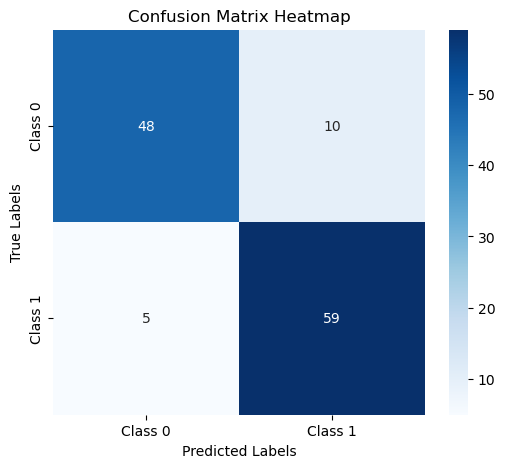

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 클래스 이름 정의
class_names = ['Class 0', 'Class 1']

# Heatmap 그리기
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_2nd, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [31]:
from sklearn.metrics import confusion_matrix

cm_valid_2nd = confusion_matrix(y_true, y_pred_valid_2nd)
print("Confusion Matrix:\n", cm_valid_2nd)


Confusion Matrix:
 [[27 31]
 [24 40]]


In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.276     0.167     0.208        48
           1      0.770     0.865     0.815       155

    accuracy                          0.700       203
   macro avg      0.523     0.516     0.511       203
weighted avg      0.653     0.700     0.671       203



In [33]:
# 모델 훈련 후
model_2nd.save_checkpoint(model_dir="./Pgp_inhibitor/checkpoint1.pt")  # 원하는 경로 지정

In [21]:
model

In [17]:
print("Train labels shape:", train_dataset.y.shape)
print("Valid labels shape:", valid_dataset.y.shape)


Train labels shape: (1624,)
Valid labels shape: (203,)
